# Numerical Methods Project

A compnay for car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

The company is interested in:

- the quality of the prediction
- the speed of the prediction
- the time required for training

## Libraries import

In [1]:
import pandas as pd
import numpy as np
import math 
import sidetable as stb
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

import lightgbm as lgb
from catboost import CatBoostRegressor

import warnings

warnings.filterwarnings('ignore')

## Data loading

In [2]:
# Loading the data from local computer
try:
    df = pd.read_csv('car_data.csv')
# Loading the data from practicum server    
except:
    df = pd.read_csv('/datasets/car_data.csv')

## Data preparation

In [3]:
# Examing the data
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
# Creating dictionary with lowercase variables names
keys = df.columns
col_dic = {}
i = 0

for key in keys:
    splitted_name = re.findall('[A-Z][^A-Z]*', keys[i])
    lowercase_name = [x.lower() for x in splitted_name]
    joined_name = '_'.join(lowercase_name)
    col_dic[key] = joined_name
    i+=1

In [5]:
# Replacing the variables' names with lowercase names
df = df.rename(columns = col_dic)

In [6]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

Replacing the variables' names was done successfully.

In [7]:
# Removing the 'postal_code' feature because it has no influence on the vehicles price
df.drop('postal_code', axis = 1, inplace = True)

In [8]:
# Checking the datatypes of the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  last_seen           354369 non-null  object
dtypes: int64(6), object(9)
memory usage: 40.6+ MB


We see that the date features **date_crawled**, **date_created** and **last_seen** is an object type instead datatype.

Also, the **date_crawled** variable is a feature that tells us when the date profile was downloaded from the database. This information is meaningless to predict the price of the vehicle, and it is basically just an informative variable like indices. Also, it has the same values as the **date_created** feature. The **last_seen** variable also has no influence on the vehicle's price - the usage patterns of the car owner of the app don't influence the car price. It doesn't matter if the user uses the app every day or once a week to check the price of his car. Therefore we will drop these 2 variables from the dataset.

In [9]:
# Removing the 'date_crawled' from the dataset
df.drop(['date_crawled', 'last_seen'], axis = 1, inplace = True)

In [10]:
# Changing the datatype of the date features
df['date_created'] = pd.to_datetime(df.date_created)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   price               354369 non-null  int64         
 1   vehicle_type        316879 non-null  object        
 2   registration_year   354369 non-null  int64         
 3   gearbox             334536 non-null  object        
 4   power               354369 non-null  int64         
 5   model               334664 non-null  object        
 6   mileage             354369 non-null  int64         
 7   registration_month  354369 non-null  int64         
 8   fuel_type           321474 non-null  object        
 9   brand               354369 non-null  object        
 10  not_repaired        283215 non-null  object        
 11  date_created        354369 non-null  datetime64[ns]
 12  number_of_pictures  354369 non-null  int64         
dtypes: datetime64[ns](1), int64(6

The conversion was done successfully.

Dates and times are rich sources of information for machine learning algorithms. But first, these features require some feature engineering to turn them into numerical data. When we converted our date variables to datetime features, we exposed all the pandas datetime properties. We can now break apart the date and get the year, month, week, day, hour, minute, second, etc. Let's apply these properties to our date features in the dataset.

In [12]:
# Braking down the datetime elements for the 'date_created' feature
df['date_created_year'] = df.date_created.dt.year
df['date_created_month'] = df.date_created.dt.month
df['date_created_day'] = df.date_created.dt.day
df['date_created_dayofweek'] = df.date_created.dt.dayofweek

warnings.filterwarnings('ignore')

In [13]:
# Checking the that the datetime elements were created correctly
df[['date_created', 'date_created_year', 'date_created_month', 'date_created_day',
     'date_created_dayofweek']].head()

,date_created,date_created_year,date_created_month,date_created_day,date_created_dayofweek
0,2016-03-24,2016,3,24,3
1,2016-03-24,2016,3,24,3
2,2016-03-14,2016,3,14,0
3,2016-03-17,2016,3,17,3
4,2016-03-31,2016,3,31,3


In [14]:
# Removing the 'date_created' feature from the dataset after turning it into numerical data
df.drop('date_created', axis = 1, inplace = True)

Let's explore our data a bit.

In [15]:
# Checking the years of profile creation
df.groupby('date_created_year').size()

date_created_year
2014         1
2015        25
2016    354343
dtype: int64

In [16]:
# Checking the distribution of years of profile creation
df.groupby('date_created_year').size() / len(df)

date_created_year
2014    0.000003
2015    0.000071
2016    0.999927
dtype: float64

In [17]:
# Checking the months of profile creation
df.groupby('date_created_month').size()

date_created_month
1      12072
2      12741
3     223819
4      13922
5      12300
6       6616
7      12803
8      11858
9      12163
10     11559
11     11656
12     12860
dtype: int64

In [18]:
# Checking the distribution of months of profile creation
df.groupby('date_created_month').size() / len(df)

date_created_month
1     0.034066
2     0.035954
3     0.631599
4     0.039287
5     0.034710
6     0.018670
7     0.036129
8     0.033462
9     0.034323
10    0.032619
11    0.032892
12    0.036290
dtype: float64

In [19]:
# Checking the days in the month of profile creation
df.groupby('date_created_day').size()

date_created_day
1        14
2        73
3     87060
4     57119
8         2
9         3
11        4
12        4
13     6025
14    12492
15    11811
16    10813
17    11132
18     5013
19    12222
20    12933
21    12714
22    11464
23    11329
24    10617
25    11716
26    11410
27    10605
28    12530
29    12139
30    11829
31    11296
dtype: int64

In [20]:
# Checking the distribution of days in the month of profile creation
df.groupby('date_created_day').size() / len(df)

date_created_day
1     0.000040
2     0.000206
3     0.245676
4     0.161185
8     0.000006
9     0.000008
11    0.000011
12    0.000011
13    0.017002
14    0.035251
15    0.033330
16    0.030513
17    0.031414
18    0.014146
19    0.034489
20    0.036496
21    0.035878
22    0.032350
23    0.031970
24    0.029960
25    0.033062
26    0.032198
27    0.029926
28    0.035359
29    0.034255
30    0.033380
31    0.031876
dtype: float64

In [21]:
# Checking the days of profile creation
df.groupby('date_created_dayofweek').size()

date_created_dayofweek
0    75101
1    43579
2    49984
3    57459
4    35987
5    49746
6    42513
dtype: int64

In [22]:
# Checking the distribution of days of profile creation
df.groupby('date_created_dayofweek').size() / len(df)

date_created_dayofweek
0    0.211929
1    0.122976
2    0.141051
3    0.162145
4    0.101552
5    0.140379
6    0.119968
dtype: float64

Let's create a new feature **'age_car'** - that will display the age of the car.


In [23]:
df['age_car'] = df['date_created_year'] - df['registration_year']
df.head(2)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,number_of_pictures,date_created_year,date_created_month,date_created_day,date_created_dayofweek,age_car
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,2016,3,24,3,23
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,2016,3,24,3,5


We created another feature 'age_car' to display the car's age. It is known that the age of a car, is one of the most important elements that influence the car price. To create it, we substracted the 'registration_year' feature from the 'date_created_year' that we created. After doing so, there is no more need for the 'date_created_year' and 'registration_year' features, **therefore we will delete these features.** 

It seems that **most of the profiles - 63%, were created in March**. Interesting - what happened in March 2016, that caused so many people to get curious what is the value of their car. If it was a real-life project with some more information about the source of the data then we would know the reason for this spike in this time period.

An interesting fact that we see in the data is that for some reason **most of the profiles were created on the 3rd and the 4th of the month**. Maybe people got creative after receiving their salaries - someone wanted to sell his car due to cash shortage while someone wanted to sell to add some amount and buy a new car. 

Also, we see that users tend to create profiles about twice as much on **Sundays** than on other days of the week.

**In summary, most of the profiles were made on Sundays of March in the year 2016.**

In [24]:
# Removing all the date related features
df.drop(['date_created_year', 'date_created_month', 
         'date_created_day', 'date_created_dayofweek', 
         'registration_month','registration_year'], axis = 1, inplace = True)

**Duplicates**

In [25]:
# Checking for duplicates
duplicated = df.duplicated().sum()
print('Number of duplicated rows:', duplicated)
print('Percentage of duplicaties: {:.2%}'.format(duplicated/len(df)))

Number of duplicated rows: 45037
Percentage of duplicaties: 12.71%


In [26]:
# Droping duplicates
df.drop_duplicates(inplace = True)

# Verifying the removal of the duplicates was done correctly
df.duplicated().sum()

0

**Numeric features distribution**

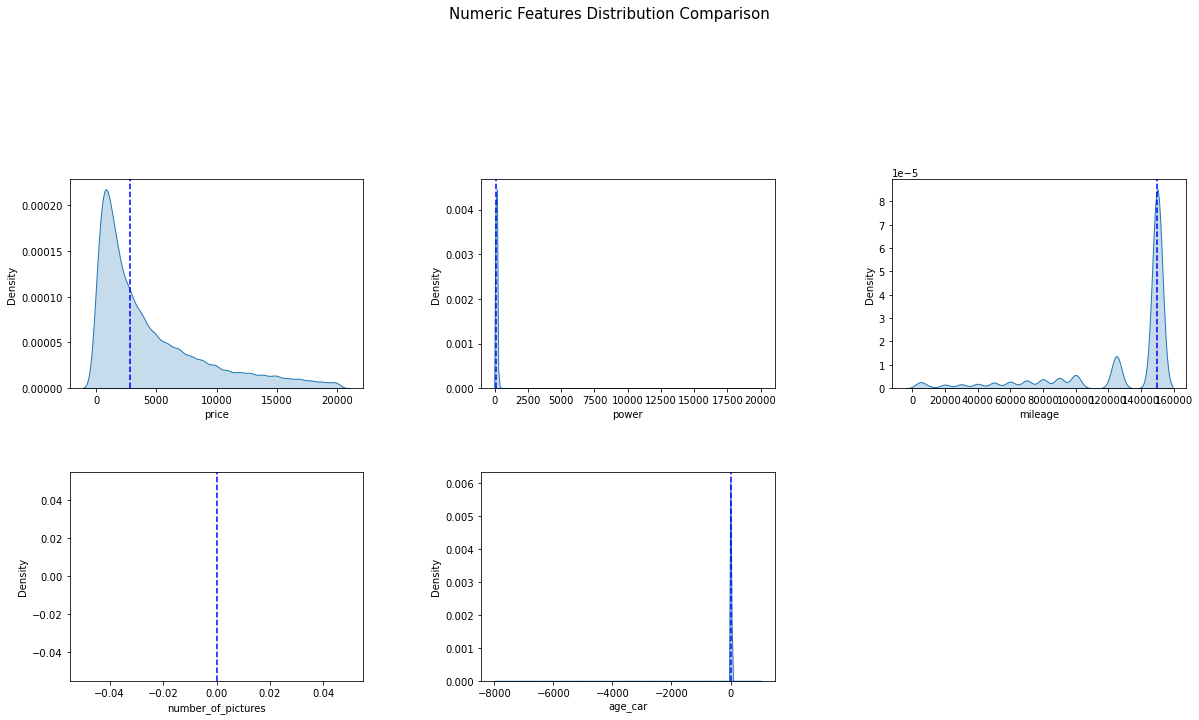

In [27]:
# Checking the distribution of the numerical variables

# Creating lists of numerical and non-numerical variables 
cat_col = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand','not_repaired']
num_col = [x for x in df.columns if x not in cat_col]

# Plotting a histogram for each numerical feature with its median
fig = plt.figure(figsize =(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Numeric Features Distribution Comparison', fontsize=15, y=1)
for i in range(1,len(num_col)+1):
    ax = fig.add_subplot(4, 3, i)
    sns.kdeplot(df[num_col[i-1]], fill=True)
    plt.ylabel('Density', fontsize=10)
    
    plt.axvline(x=df[num_col[i-1]].median(),
            color='blue',
            ls='--', 
            lw=1.5, 
            label = 'Median')

We see that many features have outliers, including the target variable - 'price'. We will take care of it in the next step. Also, we see that the 'number_of_pictures' features have only one value - 0. This means that this feature has no meaning to the price, because it has the same values for all observations, as with the 'date_created_year' feature. Therefore we will delete the 'number_of_pictures' feature.

In [28]:
df.drop('number_of_pictures', axis = 1, inplace = True)

**Outliers**

In [29]:
# Updating the list of for numrical and categorical features for boxplot plot
cat_col = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand','not_repaired']
num_col = [x for x in df.columns if x not in cat_col]

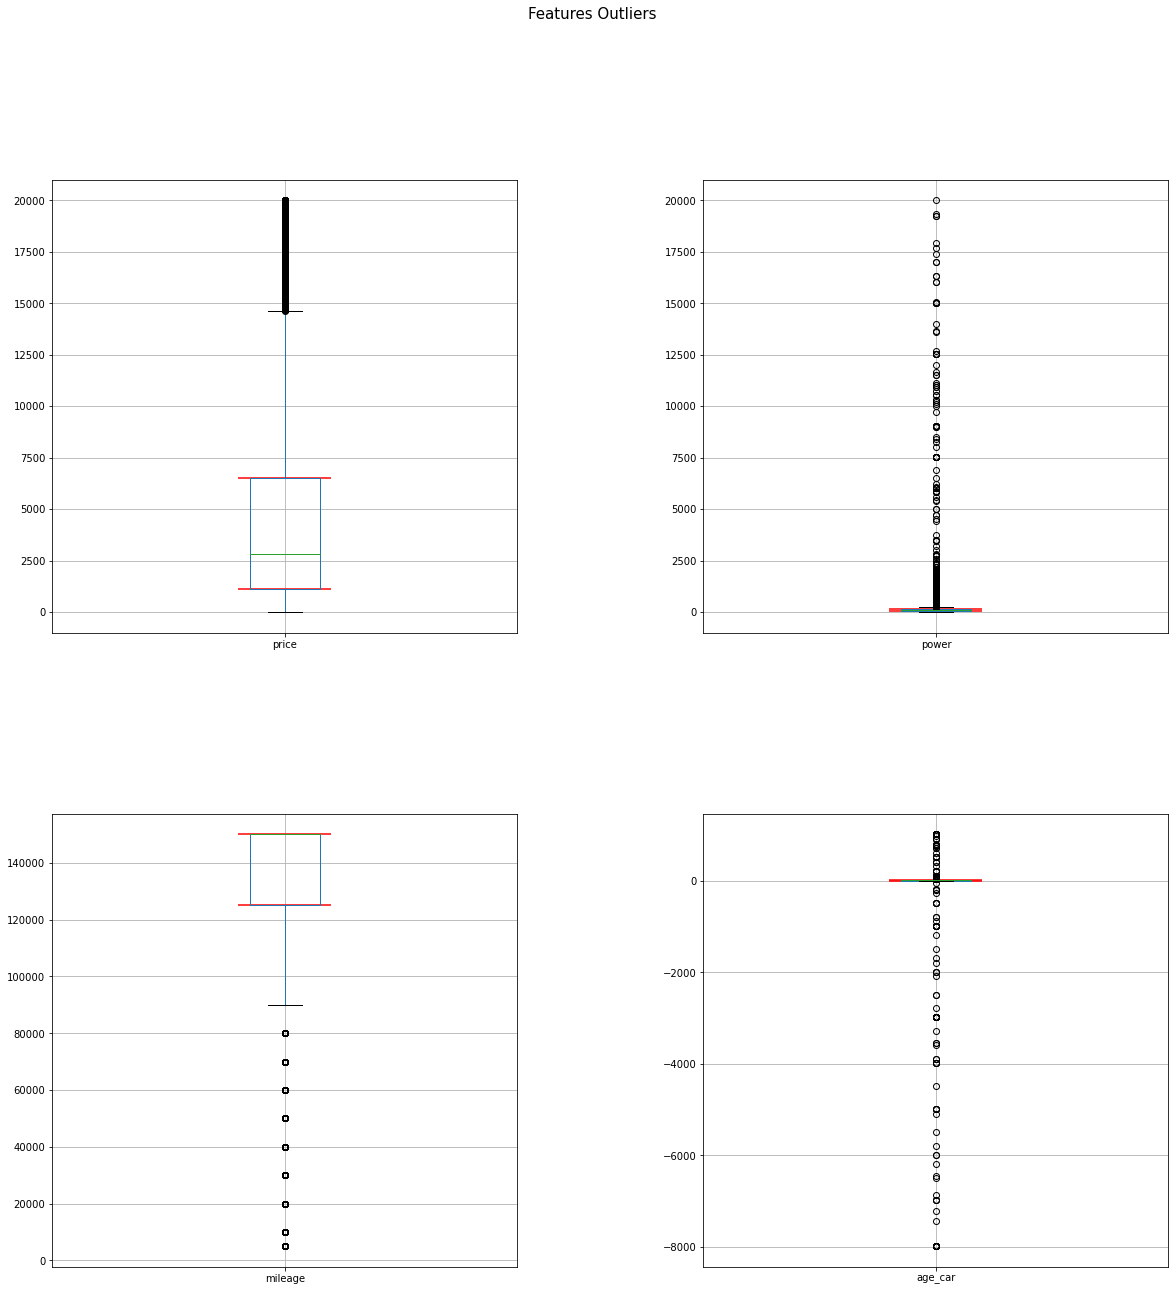

In [30]:
# Checking the outliers of the numerical variables
fig = plt.figure(figsize =(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Features Outliers', fontsize=15, y=1)
for i in range(1,len(num_col)+1):
    ax = fig.add_subplot(2, 2, i)
    df.boxplot(num_col[i-1])
    Q1 = df[num_col[i-1]].quantile(0.25)
    Q3 = df[num_col[i-1]].quantile(0.75)
    plt.hlines(y=[Q1,Q3], xmin = 0.9, xmax = 1.1, color = 'red')

We clearly see here that the following variables have significant outliers:
1. **price** - but we will not touch it because it's our target variable, and we need the model to b able to deal with expensive cars also.
2. **power**
3. **mileage** - because it is a very important feature that has significant influence on the price, we will not remove all the outliers, but onlly the values that are lower than 15,000 (a car's average mileage for a year)
4. **age_car**

In [31]:
# Removing the outliers for the 'mileage' feature
df = df[df.mileage >= 15000]

In [32]:
# Building a function for outlier removal
def outlier_removal(data, original_data):
    col = data.columns
    for i in range(len(col)):
        
        # Finding the range of quantiles Q1 and Q3
        q1 = data[col[i]].quantile(0.25)
        q3 = data[col[i]].quantile(0.75)
        iqr = q3 - q1
        box_max_0 = math.floor(q3 + 1.5*iqr)
        box_min_0 = math.ceil(q1 - 1.5*iqr)
        
        # Removing the values that exceed the quantiles range
        data.drop(data[(data[col[i]] > box_max_0) | (data[col[i]] < box_min_0)].index, inplace = True)
        
        # Removing outliers from the original dataset
        original_data.drop(original_data[(original_data[col[i]] > box_max_0) | 
                                         (original_data[col[i]] < box_min_0)].index, inplace = True)
        
        # Checking if there is 'new' outliers and removing them
        q1 = data[col[i]].quantile(0.25)
        q3 = data[col[i]].quantile(0.75)
        iqr = q3 - q1
        box_max_new = math.floor(q3 + 1.5*iqr)
        box_min_new = math.ceil(q1 - 1.5*iqr)
        
        while box_max_new < box_max_0:
            data.drop(data[(data[col[i]] > box_max_new) | (data[col[i]] < box_min_new)].index, inplace = True)
            original_data.drop(original_data[(original_data[col[i]] > box_max_new) | 
                                         (original_data[col[i]] < box_min_new)].index, inplace = True)
            box_max_0 = box_max_new
            
            q1 = data[col[i]].quantile(0.25)
            q3 = data[col[i]].quantile(0.75)
            iqr = q3 - q1
            box_max_new = math.floor(q3 + 1.5*iqr)
            box_min_new = math.ceil(q1 - 1.5*iqr)
            
            
            
                
    # Plotting the boxplot again to check the outlier removal
    fig = plt.figure(figsize =(15, 15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for j in range(1,len(col)+1):
        ax = fig.add_subplot(3, 2, j)
        data.boxplot(col[j-1])
        Q1 = data[col[j-1]].quantile(0.25)
        Q3 = data[col[j-1]].quantile(0.75)
        plt.hlines(y=[Q1,Q3], xmin = 0.9, xmax = 1.1, color = 'red')
        

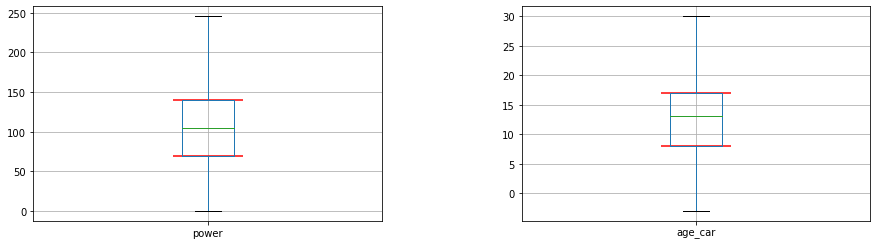

In [33]:
# Removing the outliers 
df_outliers = df[['power', 'age_car']]
outlier_removal(df_outliers, df)

All the outliers were removed. 

**Correlation between features**

In [34]:
# Building a heat map correlation function
def corr(data):
    plt.figure(figsize=(15,5))
    ax = sns.heatmap(df.corr(), annot=True, cmap='cividis')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    plt.yticks(rotation=0);

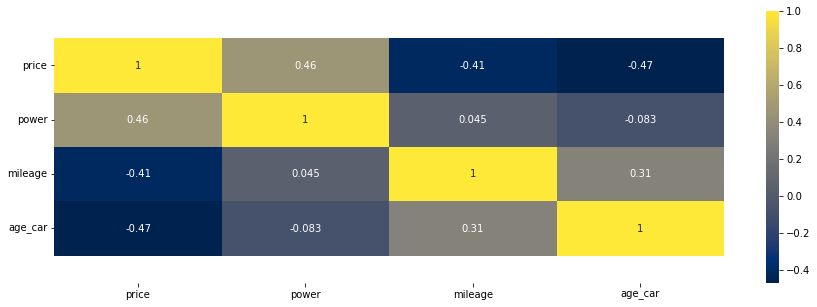

In [35]:
corr(df)

The heatmap of features correlation shows us that all the numerical features have more or less the same significant influence on the price.

**Missing values**

In [36]:
# Checking for missing values
df.stb.missing(style = True)

,missing,total,percent
not_repaired,"58,667","289,963",20.23%
vehicle_type,"31,194","289,963",10.76%
fuel_type,"27,162","289,963",9.37%
model,"15,408","289,963",5.31%
gearbox,"14,297","289,963",4.93%
price,0,"289,963",0.00%
power,0,"289,963",0.00%
mileage,0,"289,963",0.00%
brand,0,"289,963",0.00%
age_car,0,"289,963",0.00%


As we noticed before, some features have missing values. In total, we have 5 features with missing values:
1. not_repaired - with about 22% missing values
2. fuel_type - with about 8.28% missing values
3. model - with about 5.23% missing values
4. gearbox - with about 5.12% missing values
5. vehicle_type - with about 4.47% missing values

The percentage of the missing values in the dataset is significant, so we can't just drop them, because then we will lose valuable information. 

* **not_repaired** - we are going to fill the missing values with the value 'other'. This is meaningfull inforamtion that influence the price, wheter the car was demeged or not.


* **All other features** - **Instead, we are going to fill them in**. There are many approaches to filling in the missing values in a data set. One method is to **fill in the missing values with aggregation of other features, but we will not choose this path** since there are many features, and features can be intimately tied to other features in a way that we cannot manually replicate in a reliable way. In this case, we choose the KNN method that takes the row with the missing value, searches for the rows (neighbors) with the same values/closest values, and fills the missing values according to these rows. Because KNN is a distance based algorithm, to implement the KNN method we need first to follow the following steps:

1. To scale the data

2. To encode the categorical features

**Filling the missing values in the not_repaired feature**

In [37]:
# Replacing the NaN values with 'other' in 'not_repaired' feature
df.not_repaired.fillna('other', inplace = True)

In [38]:
# Checking the filling was done correctly
df.stb.missing(style = True)

,missing,total,percent
vehicle_type,"31,194","289,963",10.76%
fuel_type,"27,162","289,963",9.37%
model,"15,408","289,963",5.31%
gearbox,"14,297","289,963",4.93%
price,0,"289,963",0.00%
power,0,"289,963",0.00%
mileage,0,"289,963",0.00%
brand,0,"289,963",0.00%
not_repaired,0,"289,963",0.00%
age_car,0,"289,963",0.00%


**Scaling the numerical features**

Before splitting the features, we will delete records of brands that have less than 5 samples of a specific model. The number 5 was chosen because we are going to split the dataset in the ratio of 1:3, so a specific model needs at least 5 records to guarantee that it will appear both in the training dataset and test dataset.

In [39]:
# Creating a list of all the models that have less than 5 records
models_count = df.model.value_counts().to_frame()
models_to_remove = models_count[models_count.model < 5].index

In [40]:
df = df[df.model.isin(models_to_remove) == False]

In [41]:
df.stb.missing(style = True)

,missing,total,percent
vehicle_type,"31,192","289,958",10.76%
fuel_type,"27,162","289,958",9.37%
model,"15,408","289,958",5.31%
gearbox,"14,297","289,958",4.93%
price,0,"289,958",0.00%
power,0,"289,958",0.00%
mileage,0,"289,958",0.00%
brand,0,"289,958",0.00%
not_repaired,0,"289,958",0.00%
age_car,0,"289,958",0.00%


In [42]:
# Splitting the dataset to train and test in ratio of 25:75 before scaling
df_train, df_test = train_test_split(df, test_size = 0.25, random_state = 12345)

In [43]:
# Saving the taget variable in separate variable
price_train = df_train['price'].reset_index(drop = True)
price_test = df_test['price'].reset_index(drop = True)

In [44]:
# Setting a MinMax instance
scaler = MinMaxScaler()

# Updating the list of numerical features to keep things right
no_scale = ['vehicle_type', 'gearbox', 'model',
            'fuel_type', 'brand', 'not_repaired','price']
num_col = [x for x in df.columns if x not in no_scale]

# Scaling the relevant features in both datasets
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train[num_col].copy()), columns = num_col).reset_index(drop = True)
df_test_scaled = pd.DataFrame(scaler.transform(df_test[num_col].copy()), columns = num_col).reset_index(drop = True)

In [45]:
df_train_scaled.head(3)

,power,mileage,age_car
0,0.000000,1.000000,0.545455
1,0.182927,0.615385,0.666667
2,0.386179,0.807692,0.272727


In [46]:
df_test_scaled.head(3)

,power,mileage,age_car
0,0.406504,1.000000,0.060606
1,0.000000,1.000000,0.454545
2,0.581301,0.615385,0.454545


**Encoding the categorical features for regression models**

In [47]:
# Initiate the encoder  
encoder = OrdinalEncoder()

# Building a function to encode the categorical variables
def encode(data_train, data_test):
    
    # Retaining only non-null values
    nonulls_train = np.array(data_train.dropna())
    nonulls_test = np.array(data_test.dropna())
    
    # Reshaping the data for encoding
    impute_reshape_train = nonulls_train.reshape(-1,1)
    impute_reshape_test = nonulls_test.reshape(-1,1)
    
    # Encoding the data
    impute_ordinal_train = encoder.fit_transform(impute_reshape_train)
    impute_ordinal_test = encoder.transform(impute_reshape_test)
    
    #Assigning back encoded values to non-null values
    data_train.loc[data_train.notnull()] = np.squeeze(impute_ordinal_train)
    data_test.loc[data_test.notnull()] = np.squeeze(impute_ordinal_test)
    
    return data_train, data_test

In [48]:
cat_col

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [49]:
# Building a loop to iterate over the categorical columns to encode them in both datasets
for col in cat_col:
    encode(df_train[col], df_test[col])
    
# Setting the encoded features to unique variables    
df_train_encoded = df_train[cat_col].reset_index(drop = True)
df_test_encoded = df_test[cat_col].reset_index(drop = True)

In [50]:
df_train_encoded.head(3)

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
0,5.0,0.0,106.0,6.0,32.0,2.0
1,5.0,1.0,173.0,6.0,38.0,1.0
2,5.0,1.0,13.0,2.0,9.0,0.0


In [51]:
df_test_encoded.head(3)

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
0,NaN,1.0,116.0,NaN,38.0,0.0
1,7.0,1.0,154.0,2.0,10.0,1.0
2,4.0,0.0,59.0,6.0,20.0,0.0


We have encoded all the categorical features in both train and test sets. Now we will combine the scaled numerical features with the encoded features and the target varaible to one dataset to fill the missing values.

In [52]:
# Combining the scaled numerical features and encoded categorical features into one train dataset
df_train_features = pd.concat([df_train_scaled, df_train_encoded], axis = 1).reset_index(drop = True)

# Combining the scaled numerical features and encoded categorical features into one test dataset
df_test_features = pd.concat([df_test_scaled, df_test_encoded], axis = 1).reset_index(drop = True)

In [53]:
df_train_features.head(3)

,power,mileage,age_car,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
0,0.000000,1.000000,0.545455,5.0,0.0,106.0,6.0,32.0,2.0
1,0.182927,0.615385,0.666667,5.0,1.0,173.0,6.0,38.0,1.0
2,0.386179,0.807692,0.272727,5.0,1.0,13.0,2.0,9.0,0.0


In [54]:
df_test_features.head(3)

,power,mileage,age_car,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
0,0.406504,1.000000,0.060606,NaN,1.0,116.0,NaN,38.0,0.0
1,0.000000,1.000000,0.454545,7.0,1.0,154.0,2.0,10.0,1.0
2,0.581301,0.615385,0.454545,4.0,0.0,59.0,6.0,20.0,0.0


**Filling in the missing values**

In [55]:
# Initiate an instance of KNN imputer to fill in the missing values
imputer = KNNImputer()

# Filling in the missing values in the train dataset and adding back the target variable 'price'
df_train = pd.concat([pd.DataFrame(imputer.fit_transform(df_train_features), columns = df_train_features.columns), price_train],
                     axis = 1)

# Filling in the missing values in the test dataset and adding back the target variable 'price'
df_test = pd.concat([pd.DataFrame(imputer.transform(df_test_features), columns = df_test_features.columns), price_test],
                     axis = 1)

In [56]:
# Checking the filling proccess for the train dataset
df_train.stb.missing(style = True)

,missing,total,percent
power,0,"217,468",0.00%
mileage,0,"217,468",0.00%
age_car,0,"217,468",0.00%
vehicle_type,0,"217,468",0.00%
gearbox,0,"217,468",0.00%
model,0,"217,468",0.00%
fuel_type,0,"217,468",0.00%
brand,0,"217,468",0.00%
not_repaired,0,"217,468",0.00%
price,0,"217,468",0.00%


In [57]:
# Checking the filling proccess for the test dataset
df_test.stb.missing(style = True)

,missing,total,percent
power,0,"72,490",0.00%
mileage,0,"72,490",0.00%
age_car,0,"72,490",0.00%
vehicle_type,0,"72,490",0.00%
gearbox,0,"72,490",0.00%
model,0,"72,490",0.00%
fuel_type,0,"72,490",0.00%
brand,0,"72,490",0.00%
not_repaired,0,"72,490",0.00%
price,0,"72,490",0.00%


At this step, we cleaned the data and prepared it for model training and testing. When pre-processing the data we removed several features that didn't contribute information to model building. The features that were removed are:
1. **postal_code** - it's basically like an index of a user. It has no influence on the vehicle price.
2. **date_crawled** - this column has the same values as the date_created feature, so we deleted it to avoid duplicates.
3. **last_seen** - the user's app usage patterns have no influence on the vehicle price. The price of the car won't change if the user uses the app every day or once a month.
4. **data_created** - we removed it, after transforming it to numerical data.
5. **date_created_year** - we used to calculate the age feature.
6. **date_created_month** - it has no influence on the price. We only used it for exploring users' behaviour.
7. **date_created_year** - it has no influence on the price. We only used it for exploring users' behaviour.
8. **date_created_week** - it has no influence on the price. We only used it for exploring users' behaviour.
9. **date_created_dayofweek** - it has no influence on the price. We only used it for exploring users' behaviour.
6. **registration_year** - after creating the 'age' variable, the 'registration_year' feature become meaningless, because we transformed its' data to age.  
7. **registration_month** - it has no influence on the car's price.
8. **number_of_pictures** - it had only one value - 0. As was mentioned before, features with a single value don't contain any information for model training and testing.

Also, we **deleted duplicates**, **removed outliers**, and filled in missing values. To remove the outliers we build a function that will run on the entire dataset, and for the missing values filling, we used the KNNImputer. Before implementing the KNN method to fill in the missing values, we first scaled the numerical features and also encoded the categorical features. 

Now the data is ready for model training and testing.

## Model training

In [58]:
# Setting a list with the categorical features for gradient boosting models
cat_col = df_test_encoded.columns.to_list()

In [59]:
# Converting the encoded categorical features to integers for the gradient boosting models
for i in range(len(cat_col)):
    df_train[cat_col[i]] = df_train[cat_col[i]].astype('int')
    df_test[cat_col[i]] = df_test[cat_col[i]].astype('int')

In [60]:
# Setting the features and target variables for the train dataset
features_train = df_train.drop('price', axis = 1)
target_train = df_train.price

# Setting the features and target variables for the test dataset
features_test = df_test.drop('price', axis = 1)
target_test = df_test.price

In [61]:
# Building RMSE function 
def rmse(true_answers, predictions):
    return math.sqrt(mean_squared_error(true_answers, predictions))

In [62]:
# Create scorer for GridSearchCV
rmse = make_scorer(rmse, greater_is_better = False)

# Defining function to train non gradient models using GridSearchCV
def train_fit_rmse(model, param, name, ):
    model = GridSearchCV(model, param_grid = param, scoring = rmse, verbose = 0, refit = True)
    model.fit(features_train, target_train)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns = ['Model', 'Best_Score',
                                                                                        'Best_Params'])

In [63]:
# Defining function to train gradient boosting models using GridSearchCV
def train_fit_rmse_grad(model, param, name, grad_method, categories_list):
    model = GridSearchCV(model, param_grid = param, scoring = rmse, verbose = 0, refit = True)
    if grad_method == 'lgbm':
        model.fit(features_train, target_train, categorical_feature = categories_list)
    else:
        model.fit(features_train, target_train, silent = True, cat_features = categories_list)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns = ['Model', 'Best_Score',
                                                                                        'Best_Params'])

In [64]:
%%time
#Create Decision Tree Regressor
DecisionTree = train_fit_rmse(DecisionTreeRegressor(random_state=12345), \
                      {'max_depth': range(5, 10, 5), \
                       'min_impurity_decrease' : np.arange(.01, .20, .02), \
                       'min_samples_split' : range(2, 10, 2)}, 'Decision_Tree')

CPU times: user 25.8 s, sys: 55 ms, total: 25.9 s
Wall time: 25.9 s


In [65]:
%%time
#Create Random Forest Regressor
RandomForest = train_fit_rmse(RandomForestRegressor(random_state=12345), 
                       {'n_estimators' : range(10, 85, 25),
                        'max_depth' : range(5, 45, 10),
                        'min_impurity_decrease' : np.arange(.05, .25, .1)}, 'Random_Forest')

CPU times: user 15min 48s, sys: 5.46 s, total: 15min 53s
Wall time: 15min 54s


In [66]:
%%time

LightGBM_regressor = train_fit_rmse_grad(lgb.LGBMRegressor(random_state = 12345), 
                       {'learning_rate': np.arange(0.01, 1, 0.1),
                        'n_estimators' : range(0, 75, 25),
                        'max_depth' : range(5, 45, 10)}, 'LightGBM', 'lgbm', cat_col)

CPU times: user 10min 2s, sys: 53.8 s, total: 10min 56s
Wall time: 1min 23s


In [67]:
%%time

CatBoost_regressor = train_fit_rmse_grad(CatBoostRegressor(random_state = 12345), 
                       {'verbose':[0],
                        'n_estimators' : range(0, 75, 25),
                        'max_depth' : range(5, 45, 10)}, 'CatBoost', 'catboost', cat_col)

CPU times: user 5min 3s, sys: 8.16 s, total: 5min 11s
Wall time: 1min 38s


In [68]:
%%time
#Create Lasso Regressor (sanity check)
Lasso_regressor = train_fit_rmse(Lasso(random_state=12345), \
                        {'alpha' : np.arange(.01, 1, .05)}, 'Lasso_Regressor')

CPU times: user 13 s, sys: 2.02 s, total: 15 s
Wall time: 1.97 s


In [69]:
# Setting list of training times
time_train = ['25.9 s', '15min 53s', '1min 22s', '1min 37s', '1.86 s']

In [71]:
#Showing the best scores from all regressors
scores = pd.concat([DecisionTree, RandomForest, LightGBM_regressor, CatBoost_regressor, Lasso_regressor]).set_index('Model')
scores['Best_Score'] = scores['Best_Score'].round(2)
scores['time_train'] = time_train
display(scores.drop('Best_Params', axis=1).sort_values(by='Best_Score'))

,Best_Score,time_train
Model,,
LightGBM,1670.77,1min 22s
CatBoost,1696.55,1min 37s
Random_Forest,1720.00,15min 53s
Decision_Tree,2398.05,25.9 s
Lasso_Regressor,2904.13,1.86 s


**Testing the models**

In [72]:
# Setting s lists for time training and prediction
time_train=[]
time_pred = []

In [73]:
# Setting a dictionary for models' RMSE scores
rmse_dic = {}

In [74]:
# Building RMSE function 
def rmse_test(true_answers, predictions):
    return math.sqrt(mean_squared_error(true_answers, predictions))

In [75]:
# Building a function for model training with the best parameters
def model_train_best_params(model, x_train, y_train, model_parameters):
    model = model(**scores['Best_Params'][model_parameters])
    model.fit(x_train, y_train)
    return model

In [76]:
# Building function for model predictions and RMSE evaluation
def model_pred_rmse (model ,x_test, y_test, model_name):
    prediction = model.predict(x_test)
    model_rmse = rmse_test(y_test, prediction)
    rmse_dic[model_name] = model_rmse

**Decision Tree Regressor**

In [77]:
%%time 

# Training the Decision Tree regressor
Decision_Tree = model_train_best_params(DecisionTreeRegressor, features_train, target_train, 'Decision_Tree')

CPU times: user 190 ms, sys: 8.94 ms, total: 199 ms
Wall time: 197 ms


In [78]:
%%time

# Testing the Decision Tree Regressor
model_pred_rmse (Decision_Tree ,features_test, target_test, 'Decision_Tree')

CPU times: user 14.7 ms, sys: 6.67 ms, total: 21.4 ms
Wall time: 18.2 ms


In [79]:
# Adding the times of the Decision Tree regressor
time_train.append('203 ms')
time_pred.append('21.3 ms')

**Random Forest Regressor**

In [80]:
%%time 

# Training the Decision Tree regressor
Random_Forest = model_train_best_params(RandomForestRegressor, features_train, target_train, 'Random_Forest')

CPU times: user 15.3 s, sys: 50.4 ms, total: 15.4 s
Wall time: 15.4 s


In [81]:
%%time

# Testing the Random Forest Regressor
model_pred_rmse (Random_Forest ,features_test, target_test, 'Random_Forest')

CPU times: user 574 ms, sys: 7.47 ms, total: 581 ms
Wall time: 578 ms


In [82]:
# Adding the times of the Random_forest regressor
time_train.append('15.2 s')
time_pred.append('567 ms')

**LightGBM Regressor**

In [83]:
%%time 

# Training the LightGBM regressor
LightGBM = model_train_best_params(lgb.LGBMRegressor, features_train, target_train, 'LightGBM')

CPU times: user 1.57 s, sys: 138 ms, total: 1.7 s
Wall time: 274 ms


In [84]:
%%time

# Testing the LightGBM regressor
model_pred_rmse (LightGBM ,features_test, target_test, 'LightGBM')

CPU times: user 439 ms, sys: 15.4 ms, total: 454 ms
Wall time: 77 ms


In [85]:
# Adding the times of the LightGBM regressor
time_train.append('278 ms')
time_pred.append('64.6 ms')

**CatBoost Regressor**

In [86]:
%%time 

# Training the CatBoost regressor
CatBoost = model_train_best_params(CatBoostRegressor, features_train, target_train, 'CatBoost')

CPU times: user 16.2 s, sys: 739 ms, total: 17 s
Wall time: 7.72 s


In [87]:
%%time

# Testing the CatBoost regressor
model_pred_rmse (CatBoost ,features_test, target_test, 'CatBoost')

CPU times: user 69.8 ms, sys: 16.2 ms, total: 86 ms
Wall time: 36.6 ms


In [88]:
# Adding the times of the CatBoost regressor
time_train.append('7.9 s')
time_pred.append('40.7 ms')

**Lasso Regressor**

In [89]:
%%time 

# Training the Lasso regressor
Lasso_Regressor = model_train_best_params(Lasso, features_train, target_train, 'Lasso_Regressor')

CPU times: user 136 ms, sys: 33.6 ms, total: 169 ms
Wall time: 65.4 ms


In [90]:
%%time

# Testing the Lasso regressor
model_pred_rmse (Lasso_Regressor ,features_test, target_test, 'Lasso_Regressor')

CPU times: user 8.78 ms, sys: 2.38 ms, total: 11.2 ms
Wall time: 6.87 ms


In [91]:
# Adding the times of the Lasso regressor
time_train.append('167 ms')
time_pred.append('12.8 ms')

In [92]:
models_best_parms_rmse = pd.DataFrame(rmse_dic.values(), index = rmse_dic.keys())
models_best_parms_rmse.columns = ['RMSE']
models_best_parms_rmse['time_train'] = time_train
models_best_parms_rmse['time_pred'] = time_pred
models_best_parms_rmse = models_best_parms_rmse.sort_values(by = 'RMSE')
models_best_parms_rmse

,RMSE,time_train,time_pred
CatBoost,1660.046810,7.9 s,40.7 ms
Random_Forest,1675.010598,15.2 s,567 ms
LightGBM,1694.586455,278 ms,64.6 ms
Decision_Tree,2385.755123,203 ms,21.3 ms
Lasso_Regressor,2893.707108,167 ms,12.8 ms


## Model analysis

The run time results above tell the who is the fastest model (ascending order):
1. **Lasso Regression** 
2. **Decision Tree Regressor** 
3. **LightGBM Regressor** 
4. **CatBoost Regressor** 
5. **Random Forest Regressor** 

The combination of the running time and the RMSE scores lead us to the conclusion the **Gradient Boosting methods performed better than other regression models such as Linear Regression, Decision Tree and Random Forest**. The Gradient Boosting models have the best RMSE scores along with a very small running time. It's the perfect combination, more accurate results with less time.